In [1]:
import numpy as np
import sympy as sp
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols, Symbol,lambdify
from sympy.abc import x
f = Function('f')

eq = sin(x)*cos(f(x)) + cos(x)*sin(f(x))*f(x).diff(x)
dsolve(eq, hint='1st_exact')

[Eq(f(x), -acos(C1/cos(x)) + 2*pi), Eq(f(x), acos(C1/cos(x)))]

Eq(f(x), x*(C1 + 2*x))

2*x**2 - x

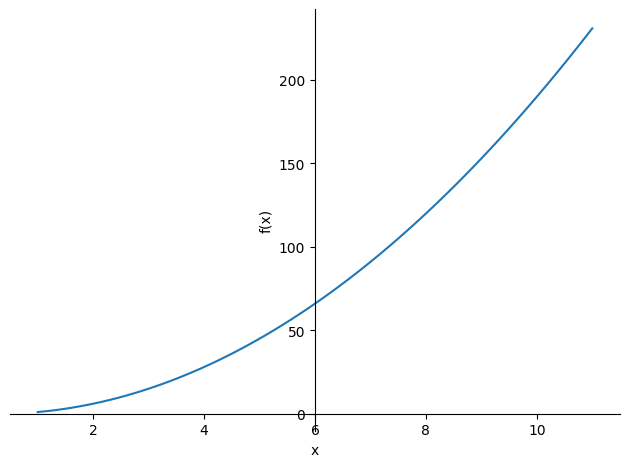

In [2]:
f = Function('f')
eq = f(x).diff(x) - f(x)/x - 2*x
solution = dsolve(eq) #, hint='1st_exact')
display(solution)
finite_solution = solution.subs(Symbol('C1'), -1).rhs
display(sp.expand(finite_solution))
sp.plot(finite_solution, (x, 1, 11))

In [3]:
fprime = f(x)/x + 2*x
fl = lambdify((x, f(x)), fprime, "numpy")
fl(np.array([1]), np.array([1]))[0]

3.0

/home/mcwave/anaconda3/envs/symbolic/lib/python3.7/site-packages/scipy/integrate/odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


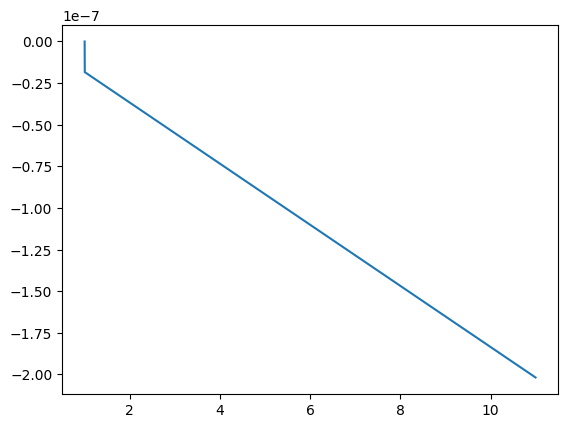

In [4]:
from tqdm import tqdm
from scipy.integrate import odeint

DELTA = 0.001
NUM_POINTS = 10000

fprime = f(x)/x + 2*x
fprime_l = lambdify((x, f(x)), fprime, "numpy")
fprime_l(np.ones(10), np.ones(10))

def derivative_func(y,t):
    return fl(np.array([t]), np.array([y]))[0]

# time points
xs = np.arange(1, 11, 0.001)

# initial condition
y0 = 1.0

# solve ODE
ys = odeint(derivative_func,y0,xs, printmessg=True)
ys = ys.flatten()

# cur = (1.0, 1.0)
# xs = [cur[0]]
# ys = [cur[1]]
# #fprime.subs({x:cur[0], f(x):cur[1]})

# pbar = tqdm(total=NUM_POINTS/10)

# for i in range(NUM_POINTS-1):
#     if i % 10 == 0:
#         pbar.update(1)
#     slope = fprime.subs({x:cur[0], f(x):cur[1]})
#     cur = (cur[0]+DELTA, cur[1]+DELTA*slope)
#     xs.append(cur[0])
#     ys.append(cur[1])

# xs = np.array(xs)
# ys = np.array(ys)

finite_solution_l = lambdify((x), finite_solution, "numpy")
actual_ys = finite_solution_l(xs)

from matplotlib import pyplot as plt
#plt.plot(xs, ys, label='euler')
#plt.plot(xs, actual_ys, label='solution')
plt.plot(xs, actual_ys-ys)
plt.show()

In [6]:
# Load symbolicregression model

import torch
import os, sys
import symbolicregression
import sympytorch
import requests

model_path = "ckpt/model.pt" 
try:
    if not os.path.isfile(model_path): 
        print("Downloading model...")
        url = "https://dl.fbaipublicfiles.com/symbolicregression/model1.pt"
        r = requests.get(url, allow_redirects=True)
        open(model_path, 'wb').write(r.content)
    if not torch.cuda.is_available():
        model = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        model = torch.load(model_path)
        model = model.cuda()
    print(model.device)
    print("Model successfully loaded!")

except Exception as e:
    print("ERROR: model not loaded! path was: {}".format(model_path))
    print(e)    
    
est = symbolicregression.model.SymbolicTransformerRegressor(
                        model=model,
                        max_input_points=10001,
                        n_trees_to_refine=5,
                        rescale=True
                        )
##Example of data
xs = np.reshape(xs, (len(xs),1))
ys = np.reshape(ys, (len(xs),1))
est.fit(xs,ys)

replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}
model_str = est.retrieve_tree(with_infos=True)["relabed_predicted_tree"].infix()
for op,replace_op in replace_ops.items():
    model_str = model_str.replace(op,replace_op)

expr = sp.parse_expr(model_str)
display(expr)

expr=sp.expand(expr)

cuda:0
Model successfully loaded!


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.96 GiB (GPU 0; 47.54 GiB total capacity; 6.43 GiB already allocated; 1.19 GiB free; 12.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF